In [1]:
import os
import numpy as np
import wfdb
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix
)
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import random
import pandas as pd
import pickle
from ecgdetectors import Detectors

In [2]:
import matplotlib.pyplot as plt
def plot_ecg_with_peaks(ecg, r_peaks, q_peaks, s_peaks, t_peaks, start=0, end=1000, title='ECG'):
    plt.figure(figsize=(15, 4))
    plt.plot(ecg[start:end], label='ECG')

    # Adjust peak indices to local window
    for peaks, label in zip([r_peaks, q_peaks, s_peaks, t_peaks], ['R', 'Q', 'S', 'T']):
        local_peaks = peaks[(peaks >= start) & (peaks < end)]
        relative_peaks = local_peaks - start  # shift to local view
        plt.scatter(relative_peaks, ecg[local_peaks], label=label)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_r_peaks(ecg, r_peaks, start=0, end=1000, title='ECG with R-peaks'):
    plt.figure(figsize=(15, 4))
    plt.plot(ecg[start:end], label='ECG Signal')
    
    # Mask to plot only R peaks in the selected window
    r_visible = r_peaks[(r_peaks >= start) & (r_peaks < end)]
    plt.scatter(r_visible, ecg[r_visible], color='red', label='R Peaks', zorder=3)
    
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pqrst_peaks(ecg, r_peaks, q_peaks=None, s_peaks=None, p_peaks=None, t_peaks=None, start=0, end=1000, title='ECG with PQRST peaks'):
    plt.figure(figsize=(15, 4))
    plt.plot(ecg[start:end], label='ECG Signal', color='black')

    # Helper function to plot visible peaks within the range
    def plot_peaks(peaks, label, color):
        if peaks is not None:
            visible = peaks[(peaks >= start) & (peaks < end)]
            plt.scatter(visible, ecg[visible], label=label, color=color, zorder=3)

    plot_peaks(p_peaks, 'P Peaks', 'orange')
    plot_peaks(q_peaks, 'Q Peaks', 'blue')
    plot_peaks(r_peaks, 'R Peaks', 'red')
    plot_peaks(s_peaks, 'S Peaks', 'green')
    plot_peaks(t_peaks, 'T Peaks', 'purple')

    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [3]:
# Define helper functions
def calc_rr(r_peaks, fs):
    return np.diff(r_peaks) / fs

def calc_qs(q_peaks, s_peaks, fs):
    return (s_peaks[:len(q_peaks)] - q_peaks[:len(s_peaks)]) / fs

def extract_features(ecg, ann, r_peaks, q_peaks, s_peaks, t_peaks, fs, comments):
    features_by_class = {'P': [], 'N': []}
    rr_intervals = calc_rr(r_peaks, fs)
    qs_intervals = calc_qs(q_peaks, s_peaks, fs)
    
    rhythm = comments[0]
    count = 0
    while count < len(ann):
        if comments[count].startswith("("):
            rhythm = comments[count]
        comments[count] = rhythm
        count += 1
    
    count = 0
    while count < len(comments):
        rhythm = comments[count]
        rhythm = rhythm.strip().replace('\x00', '')
        if rhythm in ['(P', '(N']:
            label = 'P' if rhythm == '(P' else 'N'
            start = ann[count]
            while count < len(comments) and comments[count].strip().replace('\x00', '') == rhythm:
                count += 1
            end = ann[count] if count < len(ann) else len(ecg)
            
            r_in = (r_peaks > start) & (r_peaks < end)
            q_in = (q_peaks > start) & (q_peaks < end)
            s_in = (s_peaks > start) & (s_peaks < end)
            t_in = (t_peaks > start) & (t_peaks < end)
            
            n_obs = min(np.sum(r_in), np.sum(q_in), np.sum(s_in), np.sum(t_in))

            print('label:', label)
            for i in range(n_obs):
                # if i % 100 == 0:
                #     print('->i:', i)
                feature_vector = [
                    ecg[r_peaks[r_in]][i],
                    ecg[q_peaks[q_in]][i],
                    ecg[s_peaks[s_in]][i],
                    ecg[t_peaks[t_in]][i],
                    rr_intervals[i] if i < len(rr_intervals) else 0,
                    qs_intervals[i] if i < len(qs_intervals) else 0
                ]
                features_by_class[label].append(feature_vector)
        else:
            count += 1
    return features_by_class


In [4]:
folder = 'databases/'
file_list = sorted([f for f in os.listdir(folder) if f.endswith('.hea')])
all_features = {'P': [], 'N': []}


In [5]:
for i, filename in enumerate(file_list):
    print(i, filename)

0 100.hea
1 101.hea
2 102.hea
3 103.hea
4 104.hea
5 105.hea
6 106.hea
7 107.hea
8 108.hea
9 109.hea
10 111.hea
11 112.hea
12 113.hea
13 114.hea
14 115.hea
15 116.hea
16 117.hea
17 118.hea
18 119.hea
19 121.hea
20 122.hea
21 123.hea
22 124.hea
23 200.hea
24 201.hea
25 202.hea
26 203.hea
27 205.hea
28 207.hea
29 208.hea
30 209.hea
31 210.hea
32 212.hea
33 213.hea
34 214.hea
35 215.hea
36 217.hea
37 219.hea
38 220.hea
39 221.hea
40 222.hea
41 223.hea
42 228.hea
43 230.hea
44 231.hea
45 232.hea
46 233.hea
47 234.hea
48 cu01.hea
49 cu02.hea
50 cu03.hea
51 cu04.hea
52 cu05.hea
53 cu06.hea
54 cu07.hea
55 cu08.hea
56 cu09.hea
57 cu10.hea
58 cu11.hea
59 cu12.hea
60 cu13.hea
61 cu14.hea
62 cu15.hea
63 cu16.hea
64 cu17.hea
65 cu18.hea
66 cu19.hea
67 cu20.hea
68 cu21.hea
69 cu22.hea
70 cu23.hea
71 cu24.hea
72 cu25.hea
73 cu26.hea
74 cu27.hea
75 cu28.hea
76 cu29.hea
77 cu30.hea
78 cu31.hea
79 cu32.hea
80 cu33.hea
81 cu34.hea
82 cu35.hea
83 x_108.hea
84 x_109.hea
85 x_111.hea
86 x_112.hea
87 x_113.h

Processing the ECG: databases/102
ecg: 650000 [-0.2   -0.2   -0.2   ... -0.17  -0.195  0.   ]
r_peaks: 2187
Plotting ECG segment with peaks...


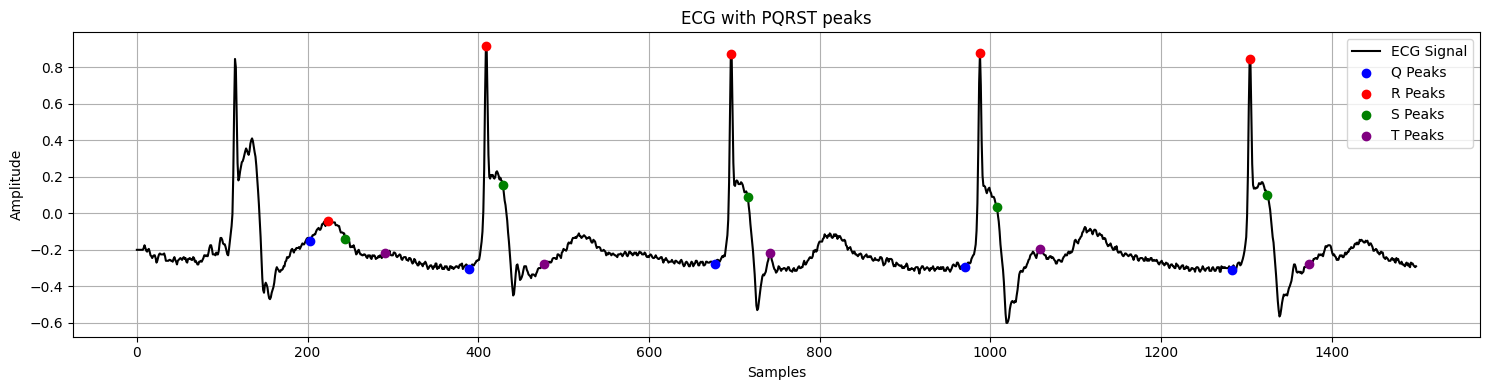

label: P
label: N
label: P
label: N
label: P
Processing the ECG: databases/104
ecg: 650000 [-0.15  -0.15  -0.15  ... -0.065 -0.06   0.   ]
r_peaks: 2341
Plotting ECG segment with peaks...


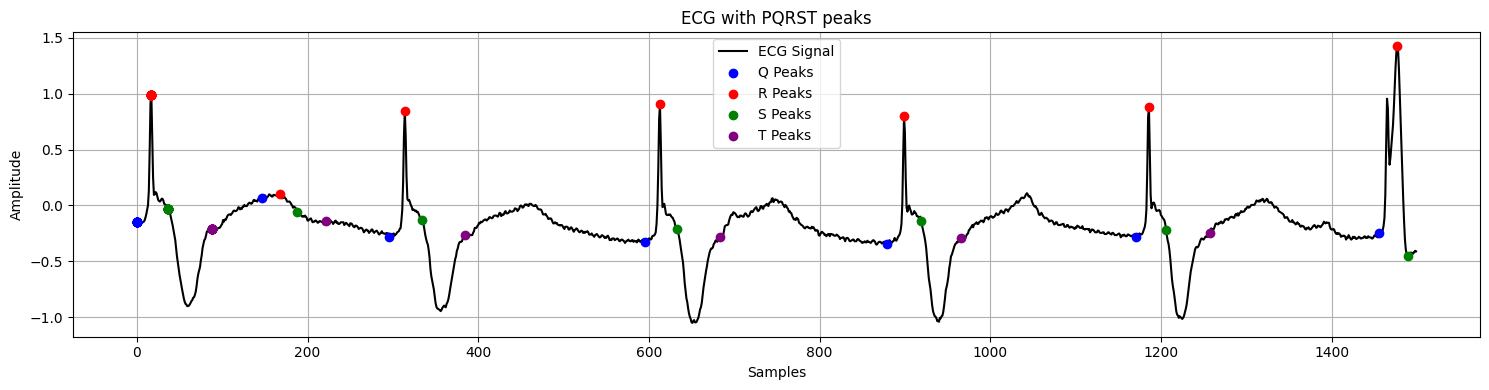

label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
label: N
label: P
Processing the ECG: databases/107
ecg: 650000 [-2.045 -2.045 -2.045 ... -0.645 -0.635  0.   ]
r_peaks: 2132
Plotting ECG segment with peaks...


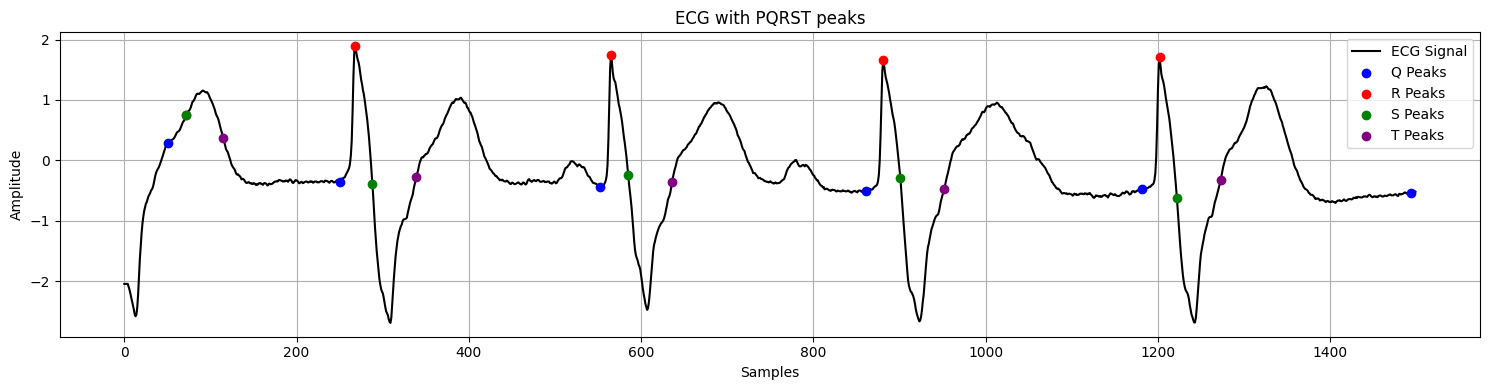

label: P
Processing the ECG: databases/217
ecg: 650000 [ 0.045  0.045  0.045 ... -0.36  -0.33   0.   ]
r_peaks: 2224
Plotting ECG segment with peaks...


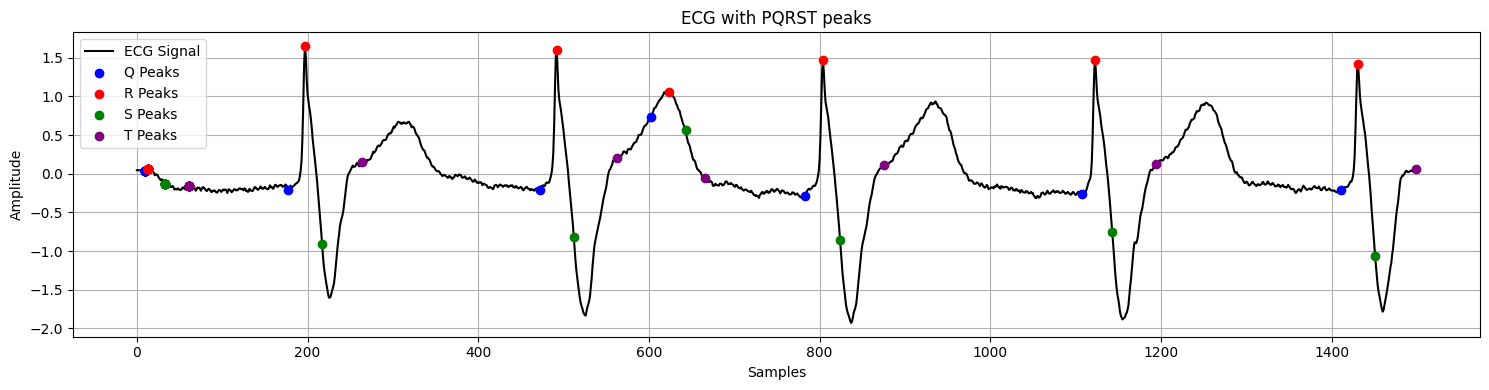

label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
label: P
All Features: {'P': [[np.float64(-0.04), np.float64(-0.15), np.float64(-0.14), np.float64(-0.22), np.float64(0.5138888888888888), np.float64(0.11388888888888889)], [np.float64(0.915), np.float64(-0.305), np.float64(0.155), np.float64(-0.28), np.float64(0.7972222222222223), np.float64(0.1111111111111111)], [np.float64(0.87), np.float64(-0.28), np.float64(0.09), np.float64(-0.22), np.float64(0.8111111111111111), np.float64(0.10833333333333334)], [np.float64(0.88), np.float64(-0.295), np.float64(0.035), np.float64(-0.195), np.float64(0.8777777777777778), np.float64(0.10277777777777777)], [np.float64(0.845), np.float64(-0.31), np.float64(0.1), np.float64(-0.275), np.float64(0.8583333333333333), np.

In [6]:
from pan_tompkins import Pan_Tompkins_QRS, heart_rate

for i, filename in enumerate(file_list):
    if i in [2, 4, 7, 36]:
        record_path = os.path.join(folder, filename[:-4])
        print('Processing the ECG:', record_path)
        try:
            ecg, fields = wfdb.rdsamp(record_path)
            ann = wfdb.rdann(record_path, 'atr')
        except Exception as e:
            print(f"Skipping {record_path}: {e}")
            continue

        ecg = ecg[:, 0]
        fs = fields['fs']
        ann_samples = ann.sample
        comments = ann.aux_note
        print('ecg:', len(ecg), ecg)

        # Convert ECG signal to the required format (if needed)
        df_ecg = pd.DataFrame({
            "TimeStamp": np.arange(len(ecg)),
            "ecg": ecg
        })
        # Run preprocessing
        QRS_detector = Pan_Tompkins_QRS(filename=record_path)
        QRS_detector.solve(df_ecg)

        # Detect R-peaks
        hr = heart_rate(ecg, fs)
        r_peaks = np.array(hr.find_r_peaks())
        r_peaks = r_peaks[r_peaks > 0]  # remove invalid indices

        print('r_peaks:', len(r_peaks))

        q_peaks, s_peaks, t_peaks = [], [], []

        for r in r_peaks:
            # Q peak: ~60ms before R
            q_start = max(r - int(0.06 * fs), 0)
            q_valley = np.argmin(ecg[q_start:r]) if r > q_start else 0
            q_peaks.append(q_start + q_valley)

            # S peak: ~60ms after R
            s_end = min(r + int(0.06 * fs), len(ecg) - 1)
            s_valley = np.argmin(ecg[r:s_end]) if s_end > r else 0
            s_peaks.append(r + s_valley)

            # T peak: 120–200ms after R
            t_start = r + int(0.12 * fs)
            t_end = r + int(0.2 * fs)
            t_start = min(t_start, len(ecg) - 1)
            t_end = min(t_end, len(ecg))
            if t_end > t_start:
                t_peak = np.argmax(ecg[t_start:t_end])
                t_peaks.append(t_start + t_peak)

        r_peaks = np.array(r_peaks)
        q_peaks = np.array(q_peaks)
        s_peaks = np.array(s_peaks)
        t_peaks = np.array(t_peaks)

        if len(ann_samples) > 100:
            print("Plotting ECG segment with peaks...")
            plot_pqrst_peaks(ecg, r_peaks, q_peaks=q_peaks, s_peaks=s_peaks, t_peaks=t_peaks, start=0, end=1500)
        features_by_class = extract_features(ecg, ann_samples, r_peaks, q_peaks, s_peaks, t_peaks, fs, comments)
        # print('Features by class:', features_by_class)
        for cls in features_by_class:
            all_features[cls].extend(features_by_class[cls])

print('All Features:', all_features)

In [7]:
X_paced = np.array(all_features['P'])
X_normal = np.array(all_features['N'])

print(len(X_paced), len(X_normal))

X = np.vstack((X_paced, X_normal))
Y = np.array([1]*len(X_paced) + [0]*len(X_normal))

print(X)
print(Y)
print(len(X), len(Y))

8028 426
[[-0.04       -0.15       -0.14       -0.22        0.51388889  0.11388889]
 [ 0.915      -0.305       0.155      -0.28        0.79722222  0.11111111]
 [ 0.87       -0.28        0.09       -0.22        0.81111111  0.10833333]
 ...
 [ 1.135      -0.28       -0.53       -0.5         0.          0.10277778]
 [ 0.93        0.035      -0.36       -0.32        0.          0.10277778]
 [ 0.785      -0.225      -0.125      -0.175       0.          0.10277778]]
[1 1 1 ... 0 0 0]
8454 8454


In [8]:
# Shuffle data
idx = np.random.permutation(len(Y))
X = X[idx]
Y = Y[idx]



In [9]:
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

# Remove samples with NaNs before training
nan_mask = ~np.isnan(X).any(axis=1)
X = X[nan_mask]
Y = Y[nan_mask]

print(len(X), len(Y))

8454 8454


In [10]:
# Cross-validation
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds)
metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'auc': []}

for fold, (train_idx, test_idx) in enumerate(skf.split(X, Y), 1):
    print('->fold:', fold)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    w_paced = 1 / np.sum(y_train == 1)
    w_normal = 1 / np.sum(y_train == 0)
    weights = np.where(y_train == 1, w_paced, w_normal)
    weights = weights * len(y_train) / np.sum(weights)

    clf = SVC(kernel='linear', probability=True, class_weight=None)
    print("starting to fit")
    clf.fit(X_train, y_train, sample_weight=weights)
    print("done fitting")

    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]

    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
    metrics['recall'].append(recall_score(y_test, y_pred, zero_division=0))
    metrics['f1'].append(f1_score(y_test, y_pred, zero_division=0))
    metrics['auc'].append(roc_auc_score(y_test, y_score))
    print("metrics:", metrics)



->fold: 1
starting to fit
done fitting
metrics: {'accuracy': [0.8497930218805441], 'precision': [0.980796586059744], 'recall': [0.8586550435865504], 'f1': [0.9156706507304117], 'auc': [0.7888140062999048]}
->fold: 2
starting to fit
done fitting
metrics: {'accuracy': [0.8497930218805441, 0.8462448255470136], 'precision': [0.980796586059744, 0.986271676300578], 'recall': [0.8586550435865504, 0.8499377334993773], 'f1': [0.9156706507304117, 0.9130434782608695], 'auc': [0.7888140062999048, 0.8335360046883012]}
->fold: 3
starting to fit
done fitting
metrics: {'accuracy': [0.8497930218805441, 0.8462448255470136, 0.8450620934358368], 'precision': [0.980796586059744, 0.986271676300578, 0.9820659971305595], 'recall': [0.8586550435865504, 0.8499377334993773, 0.8524283935242839], 'f1': [0.9156706507304117, 0.9130434782608695, 0.9126666666666666], 'auc': [0.7888140062999048, 0.8335360046883012, 0.8010035894806241]}
->fold: 4
starting to fit
done fitting
metrics: {'accuracy': [0.8497930218805441, 0.

In [11]:
for key in metrics:
    values = metrics[key]
    print(f"Mean {key.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f}")


Mean Accuracy: 0.8508 ± 0.0050
Mean Precision: 0.9811 ± 0.0030
Mean Recall: 0.8595 ± 0.0077
Mean F1: 0.9163 ± 0.0032
Mean Auc: 0.7930 ± 0.0303


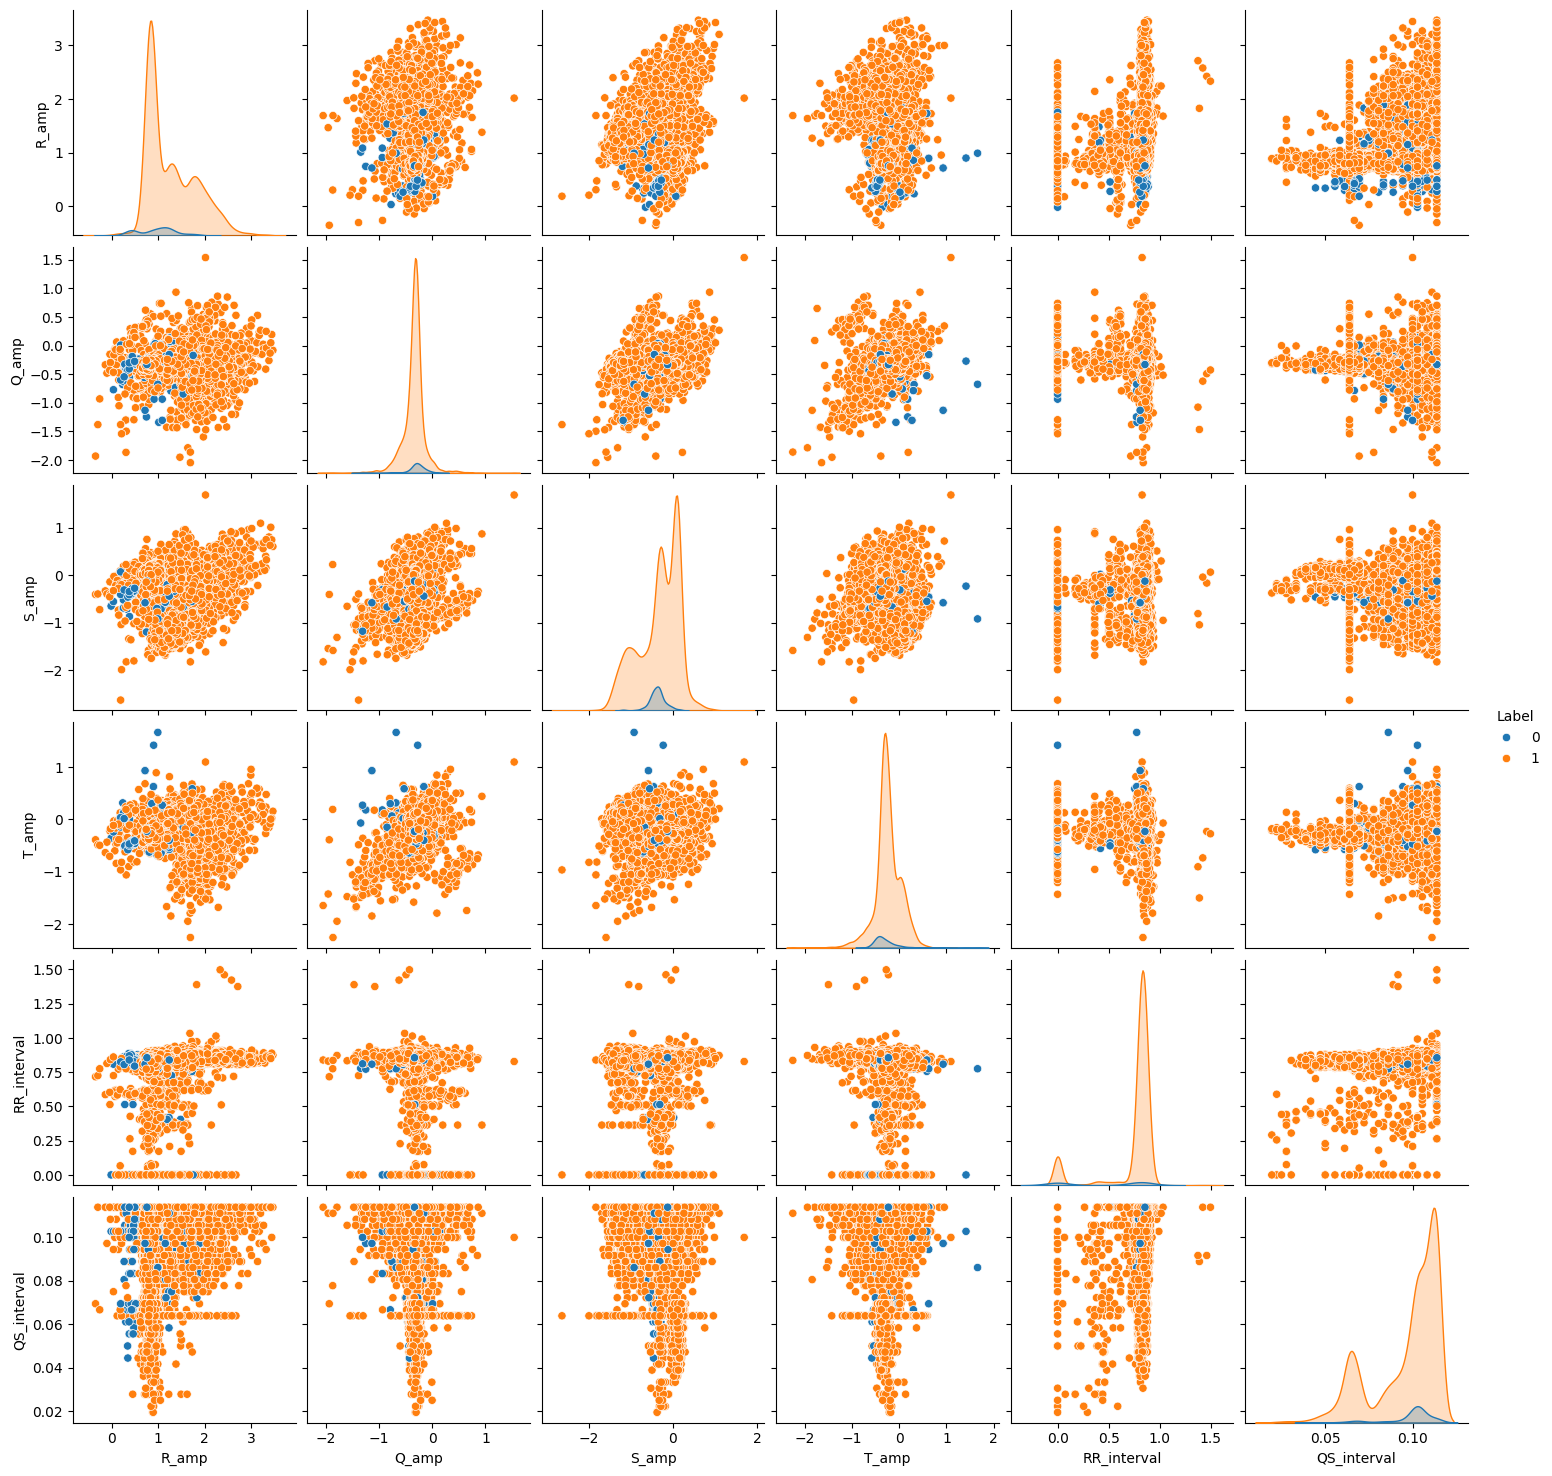

In [12]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X, columns=["R_amp", "Q_amp", "S_amp", "T_amp", "RR_interval", "QS_interval"])
df["Label"] = Y
sns.pairplot(df, hue="Label")
plt.show()
